# Test PEtab + roadrunner + pyPESTO + pocoMC

## Import libraries and load PEtab problem

In [1]:
import numpy as np
import petab
import pocomc as pc
import pypesto.objective
import pypesto.optimize as optimize
import pypesto.objective.roadrunner as pypesto_rr
import pypesto.sample as sample
import pypesto.visualize as visualize
import pypesto.profile as profile
import pypesto.store as store
import pypesto.logging as log
from IPython.display import Markdown, display
import pypesto.history as history
from pprint import pprint
import matplotlib.pyplot as plt

np.random.seed(123)

model_name = "Michaelis_Menten"

In [2]:
petab_yaml = f"./{model_name}/{model_name}.yaml"

petab_problem = petab.Problem.from_yaml(petab_yaml)
importer = pypesto_rr.PetabImporterRR(petab_problem)
problem = importer.create_problem()


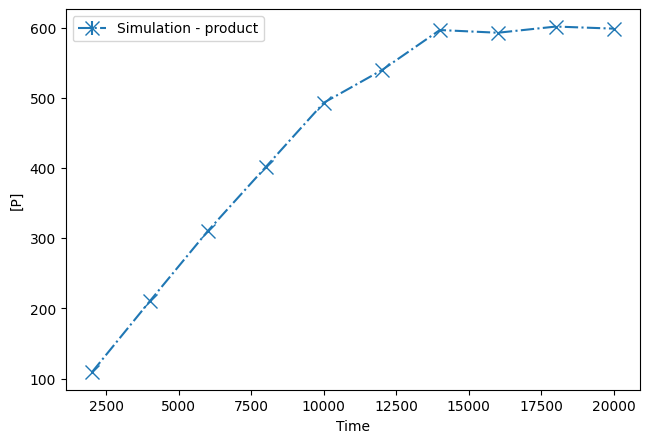

In [3]:
petab.visualize.plot_problem(petab_problem);
plt.gcf().set_size_inches(6, 4)

In [4]:
ret = problem.objective(
    petab_problem.get_x_nominal(fixed=False,scaled=True),
    mode="mode_fun",
    return_dict=True,
)
pprint(ret)

{'fval': 177.58442025403264, 'rdatas': []}


In [ ]:
import scipy
print(scipy.optimize.show_options("minimize", method="Nelder-Mead"))

In [ ]:
solver_options = pypesto_rr.SolverOptions(
    relative_tolerance = 5e-10,
    absolute_tolerance = 1e-10,
)
engine = pypesto.engine.MultiProcessEngine()
problem.objective.solver_options = solver_options

In [ ]:

print(problem.objective.history)
history_options = history.HistoryOptions(trace_record=True)
hist_opts = history.HistoryOptions.assert_instance(history_options)
problem.objective.__setattr__("history", problem.objective.create_history("ch1", x_names=problem.objective.x_names, options=hist_opts))
print(problem.objective.history)

## OPTIONAL: Run local optimization using Nelder-Mead

In [ ]:
"""
optimizer = optimize.ScipyOptimizer(method="Nelder-Mead", options={"maxiter":10000})

result = optimize.minimize(
    problem=problem,
    optimizer=optimizer,
    n_starts=100,  # usually a value >= 100 should be used
    engine=engine
)
display(Markdown(result.summary()))
"""


In [ ]:
"""
sampler = sample.MetropolisSampler()
sampler.initialize(problem=problem, x0=np.array([-1,1,0]))
print(sampler.neglogpost.history)

history_options = history.HistoryOptions(trace_record=True)
hist_opts = history.HistoryOptions.assert_instance(history_options)
sampler.neglogpost.__setattr__("history", problem.objective.create_history("ch1", x_names=problem.objective.x_names, options=hist_opts))
print(sampler.neglogpost.history)"""

## Run PT-MCMC

In [ ]:
sampler = sample.AdaptiveParallelTemperingSampler(
    internal_sampler=sample.AdaptiveMetropolisSampler(), n_chains=4
)
sampler.initialize(problem=problem, x0=np.array([-1,1,0]))
print(sampler.__dict__.keys())

for internal_sampler in sampler.samplers:
	history_options = history.HistoryOptions(trace_record=True)
	hist_opts = history.HistoryOptions.assert_instance(history_options)
	internal_sampler.neglogpost.__setattr__("history", problem.objective.create_history("ch1", x_names=problem.objective.x_names, options=hist_opts))


In [ ]:
%%time
sampler.sample(n_samples=10000);

#sample.effective_sample_size(result);
#sample.auto_correlation(result);

In [ ]:
for internal_sampler in sampler.samplers:
	print(internal_sampler.neglogpost.history.__dict__["_n_fval"])

In [ ]:
print(sampler.neglogpost.history.__dict__.keys())
print(sampler.neglogpost.history.__dict__["_n_fval"])

## Translate pyPESTO problem into functions used by pocoMC

In [ ]:
lower_bnds = problem.lb
upper_bnds = problem.ub
neglogprior = sampler.samplers[0].neglogprior
"""
def log_prior(x):
    bools = [
        (low <= i <= high)
        for i, low, high in zip(x, lower_bnds, upper_bnds)
    ]
    all_in_range = np.all(bools)
    if all_in_range:
        return -neglogprior(x)
    return -np.inf
    """

def log_likelihood(x):
	result = problem.objective(x=x, return_dict=True)
	return result["llh"]

print(log_likelihood([-2.77,-1,-2]), log_likelihood([1,3,-2]))

from scipy.stats import uniform

prior = pc.Prior([uniform(loc=lb, scale=np.abs(ub-lb)) for lb,ub in zip(lower_bnds, upper_bnds)])
                  

## Run PMC

In [ ]:
# Initialise sampler
pmc_sampler = pc.Sampler(
    prior=prior,
    likelihood=log_likelihood,
    vectorize=False,
    random_state=0,
	dynamic=True
)

In [ ]:
pmc_sampler.run()

In [ ]:
import matplotlib.pyplot as plt
import corner

# Get the results
samples, weights, logl, logp = pmc_sampler.posterior()

# Trace plot for the first 4 parameters
fig = corner.corner(samples, weights=weights, color="C0")
plt.show()